In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, precision_recall_curve)


In [2]:
# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### **Load and explore data**

In [3]:
df = pd.read_csv("heart_disease_uci.csv")

In [4]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [5]:
df.columns

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

In [6]:
# Initial inspection
print("="*50)
print("Initial Data Inspection")
print("="*50)
# Shape of data
print(f"Shape: {df.shape}")
# Top rows
print("\nFirst 5 rows:")
print(df.head())
# Information of data
print("\nData Info:")
print(df.info())
# Dataset description
print("\nDescriptive Statistics:")
print(df.describe(include='all').T)
# Missing values
print("\nMissing Values:")
print(df.isnull().sum())

Initial Data Inspection
Shape: (920, 16)

First 5 rows:
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3       

### **Data preprocessing and cleaning**

In [7]:
# Step 1: Remove unnecessary columns
df = df.drop('id', axis=1)
print("Dropped 'id' column")

Dropped 'id' column


In [8]:
# Step 2: Convert target to binary (0: No HD, 1: HD)
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df = df.drop('num', axis=1)
print("Created binary target variable")

Created binary target variable


In [9]:
# Step 3: Handle missing values
# Identify columns with special placeholder values (typical in medical datasets)
missing_indicators = {'ca': [4, 5, 9], 'thal': [0, 3, 7]}

for col, values in missing_indicators.items():
    df[col] = df[col].replace(values, np.nan)
    print(f"Converted {values} to NaN in {col}")

# Calculate missing values
print("\nMissing Values After Conversion:")
print(df.isnull().sum())

# Handle missing data
df['ca'] = df['ca'].fillna(df['ca'].median())
df['thal'] = df['thal'].fillna(df['thal'].mode()[0])
print("\nMissing values imputed:")
print(df.isnull().sum().sum(), "missing values remaining")

Converted [4, 5, 9] to NaN in ca
Converted [0, 3, 7] to NaN in thal

Missing Values After Conversion:
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

Missing values imputed:
662 missing values remaining


In [10]:
# Step 4: Convert data types
categorical_cols = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
df[categorical_cols] = df[categorical_cols].astype('category')
print("\nConverted categorical columns to proper data type")


Converted categorical columns to proper data type


In [11]:
# Step 5: Remove duplicates
initial_count = len(df)
df = df.drop_duplicates()
final_count = len(df)
print(f"\nRemoved {initial_count - final_count} duplicate rows")


Removed 2 duplicate rows


In [12]:
# Step 6: Outlier handling
print("\nOutlier Analysis:")
Q1 = df[['trestbps', 'chol', 'thalch']].quantile(0.25)
Q3 = df[['trestbps', 'chol', 'thalch']].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((df[['trestbps', 'chol', 'thalch']] < lower_bound) |
            (df[['trestbps', 'chol', 'thalch']] > upper_bound)).any(axis=1)
print(f"Detected {outliers.sum()} outliers using IQR method")

# Cap outliers instead of removing
for col in ['trestbps', 'chol', 'thalch']:
    df[col] = np.where(df[col] < lower_bound[col], lower_bound[col], df[col])
    df[col] = np.where(df[col] > upper_bound[col], upper_bound[col], df[col])
print("Capped outliers using IQR boundaries")


Outlier Analysis:
Detected 203 outliers using IQR method
Capped outliers using IQR boundaries


### **Exploratory Data Analysis**

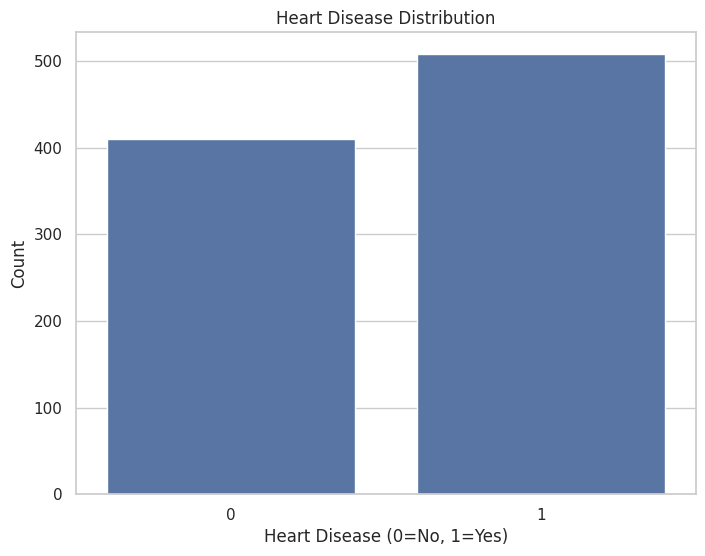


Target Distribution:
target
1    0.553377
0    0.446623
Name: proportion, dtype: float64


In [13]:
# Target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df)
plt.title('Heart Disease Distribution')
plt.xlabel('Heart Disease (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()
print("\nTarget Distribution:")
print(df['target'].value_counts(normalize=True))

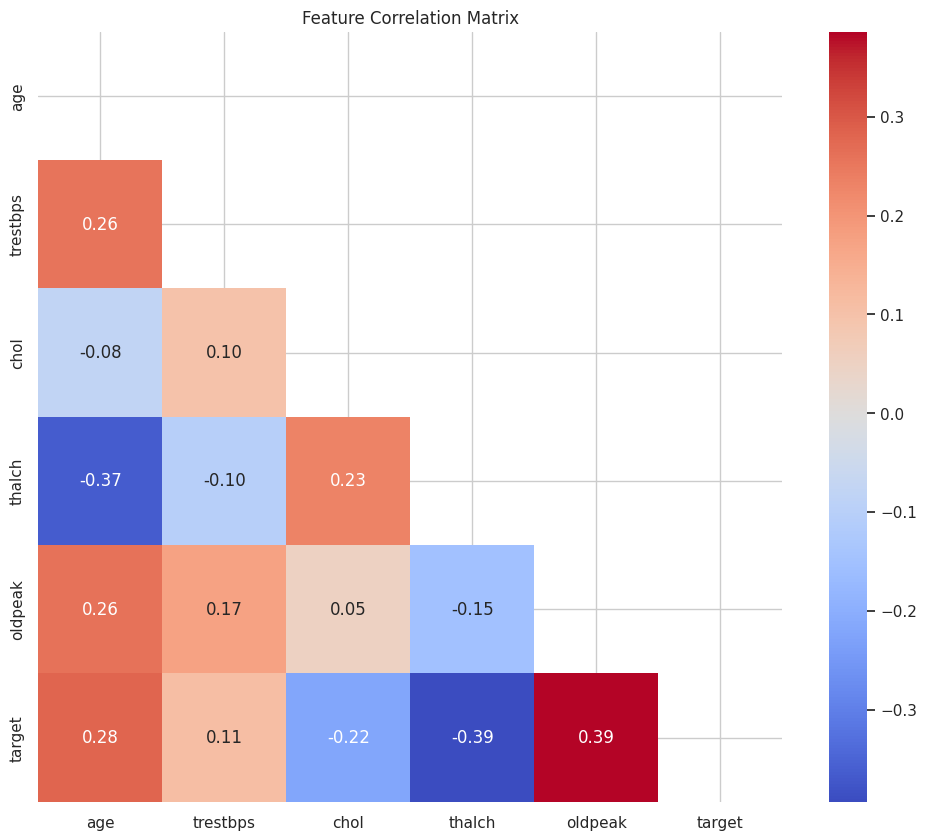


Top Correlations with Target:
target      1.000000
oldpeak     0.386106
age         0.282039
trestbps    0.109018
chol       -0.221729
thalch     -0.393432
Name: target, dtype: float64


In [14]:
# Correlation analysis
plt.figure(figsize=(12, 10))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title('Feature Correlation Matrix')
plt.show()

print("\nTop Correlations with Target:")
print(corr_matrix['target'].sort_values(ascending=False))

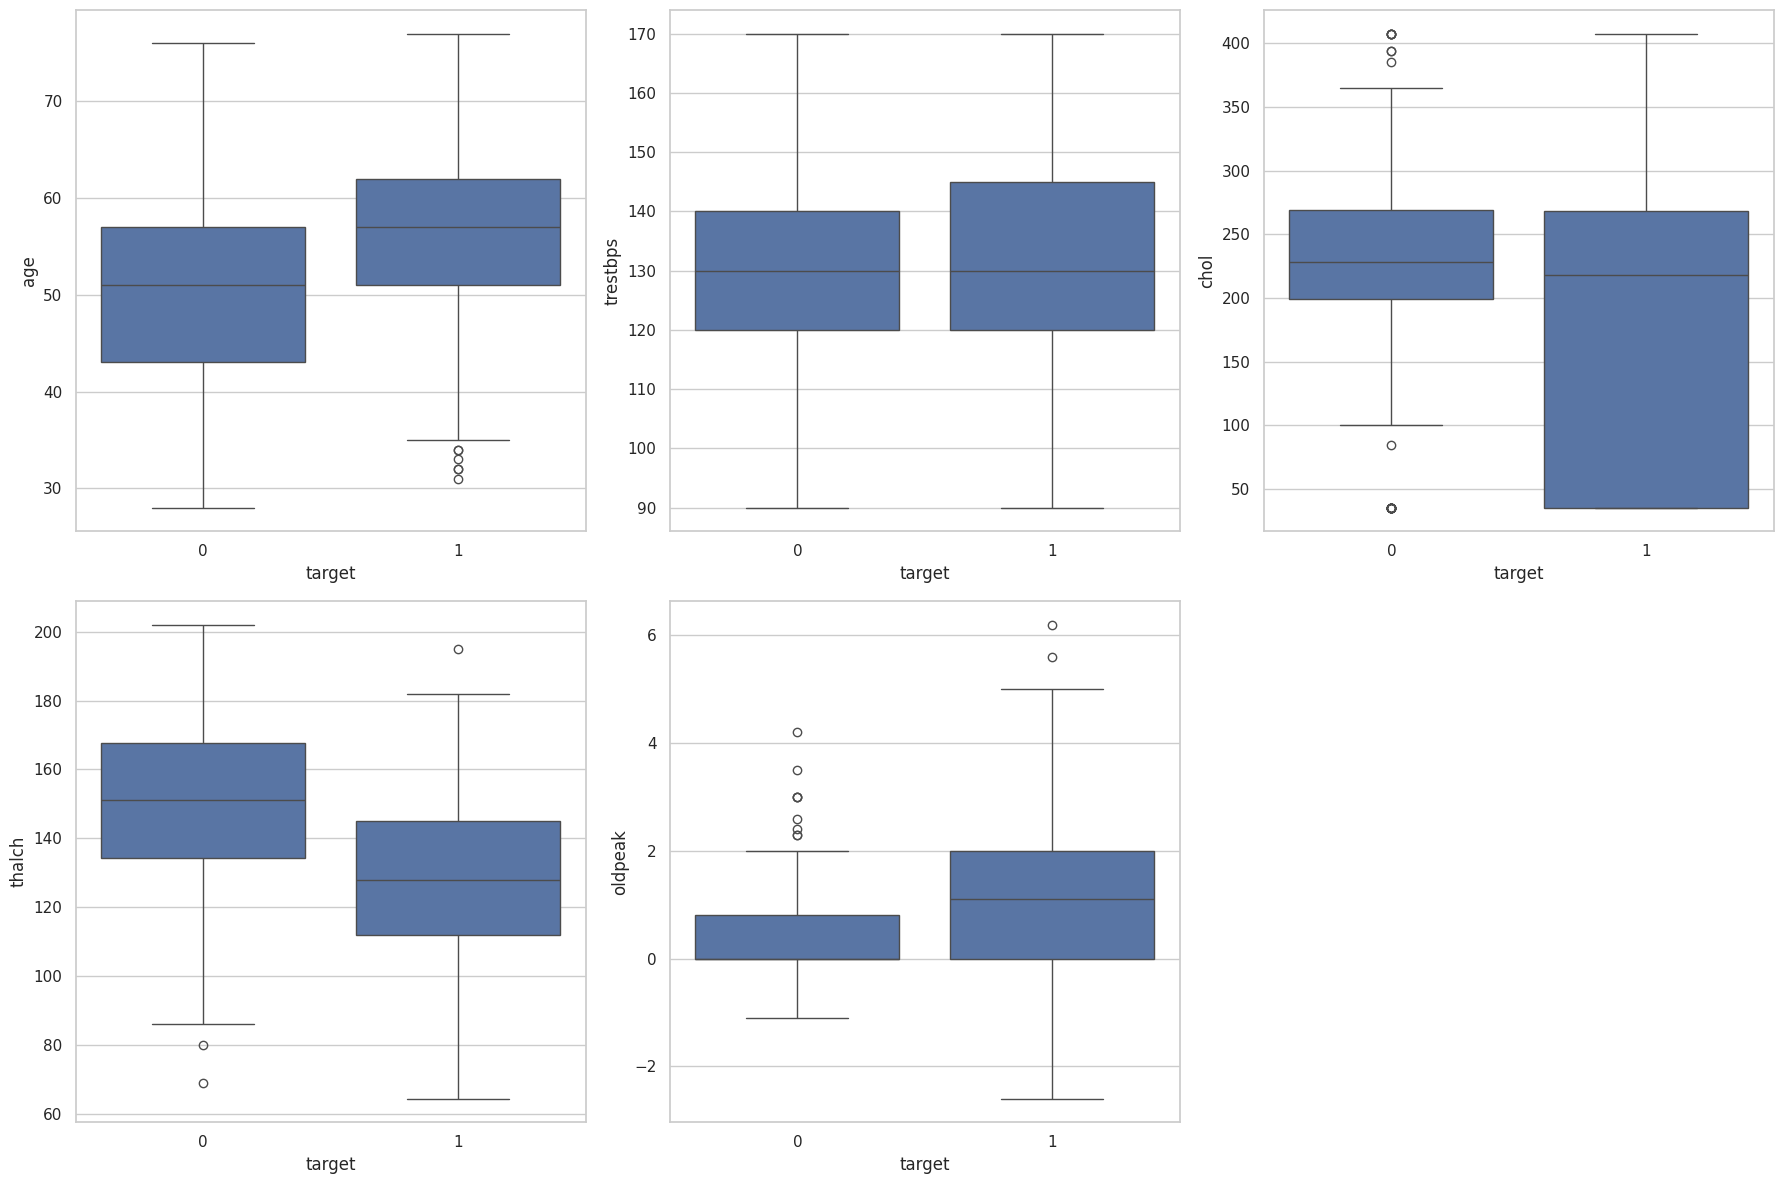

In [15]:
# Feature distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
sns.boxplot(x='target', y='age', data=df, ax=axes[0, 0])
sns.boxplot(x='target', y='trestbps', data=df, ax=axes[0, 1])
sns.boxplot(x='target', y='chol', data=df, ax=axes[0, 2])
sns.boxplot(x='target', y='thalch', data=df, ax=axes[1, 0])
sns.boxplot(x='target', y='oldpeak', data=df, ax=axes[1, 1])
axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

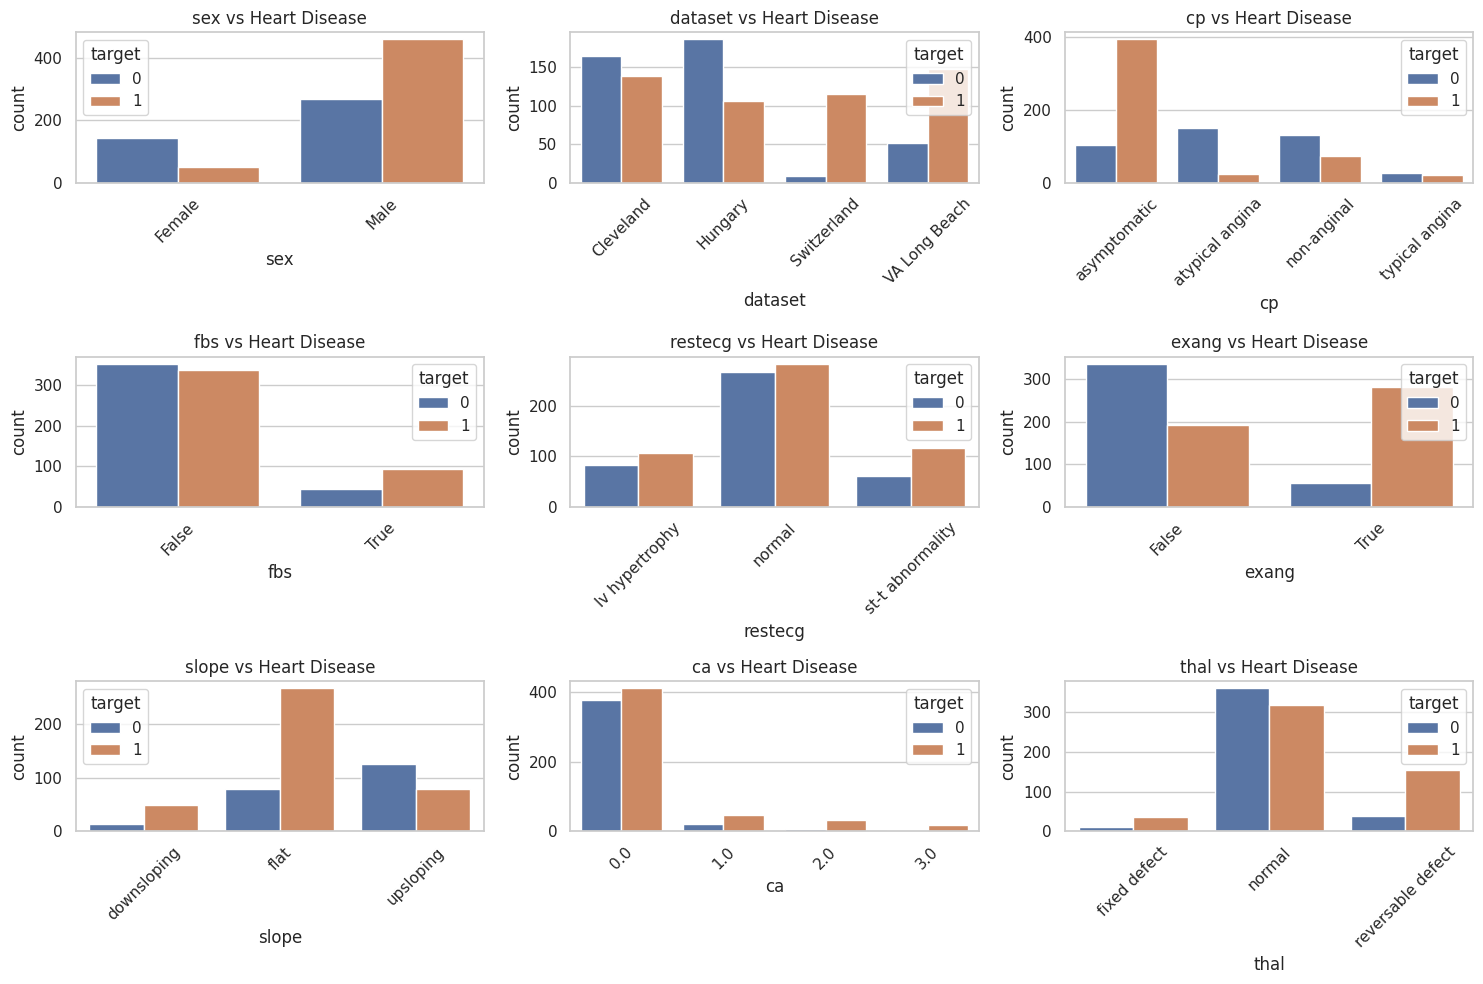

In [16]:
# Categorical feature analysis
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i+1)
    sns.countplot(x=col, hue='target', data=df)
    plt.title(f'{col} vs Heart Disease')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Feature Engineering and Preparation**

In [17]:
#Create age groups
df['age_group'] = pd.cut(df['age'],
                         bins=[20, 40, 50, 60, 70, 100],
                         labels=['20-40', '40-50', '50-60', '60-70', '70+'])

In [18]:
# Encode categorical variables
df = pd.get_dummies(df, columns=categorical_cols + ['age_group'], drop_first=True)
print(f"Shape after one-hot encoding: {df.shape}")

Shape after one-hot encoding: (918, 28)


In [19]:
# Final check for missing values
print("\nFinal missing value check:")
print(df.isnull().sum().sum(), "missing values remaining")


Final missing value check:
205 missing values remaining


In [20]:
# Handle any remaining missing values
if df.isnull().sum().sum() > 0:
    print("Handling remaining missing values...")
    # Fill numerical columns with median
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)

    # Fill categorical/dummy columns with 0
    dummy_cols = df.select_dtypes(include=['uint8']).columns
    for col in dummy_cols:
        df[col].fillna(0, inplace=True)

Handling remaining missing values...


/tmp/ipython-input-20-1511191579.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [21]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

In [22]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
# Final NaN check after scaling
if np.isnan(X_scaled).any():
    print("Replacing NaNs in scaled data with 0")
    X_scaled = np.nan_to_num(X_scaled)

In [24]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Class balance in train: {np.mean(y_train):.2f}, test: {np.mean(y_test):.2f}")


Train shape: (642, 27), Test shape: (276, 27)
Class balance in train: 0.55, test: 0.55


### **Model training and evaluation**

In [25]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Comprehensive model evaluation function"""
    # Train predictions
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None

    # Test predictions
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred, zero_division=0),
        'Recall': recall_score(y_test, y_test_pred),
        'F1': f1_score(y_test, y_test_pred),
        'ROC AUC': roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
    }

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)

    # Classification report
    cr = classification_report(y_test, y_test_pred, zero_division=0)

    return metrics, cm, cr


In [26]:
# Model 1: Logistic Regression with enhanced error handling
print("\nTraining Logistic Regression with NaN safeguard...")

# Create a pipeline with imputation and model
logreg_pipe = make_pipeline(
    SimpleImputer(strategy='median'),  # Additional safeguard
    StandardScaler(),  # Add scaler for logistic regression
    LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
)

param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear']
}

logreg_cv = GridSearchCV(
    logreg_pipe,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    error_score='raise'
)
logreg_cv.fit(X_train, y_train)

print(f"Best parameters: {logreg_cv.best_params_}")
best_logreg = logreg_cv.best_estimator_

logreg_metrics, logreg_cm, logreg_cr = evaluate_model(
    best_logreg, X_train, y_train, X_test, y_test
)

print("\nLogistic Regression Results:")
print(f"Accuracy: {logreg_metrics['Accuracy']:.4f}")
print(f"Precision: {logreg_metrics['Precision']:.4f}")
print(f"Recall: {logreg_metrics['Recall']:.4f}")
print(f"F1 Score: {logreg_metrics['F1']:.4f}")
print(f"ROC AUC: {logreg_metrics['ROC AUC']:.4f}")
print("\nConfusion Matrix:")
print(logreg_cm)
print("\nClassification Report:")
print(logreg_cr)


Training Logistic Regression with NaN safeguard...
Best parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}

Logistic Regression Results:
Accuracy: 0.8188
Precision: 0.8552
Recall: 0.8105
F1 Score: 0.8322
ROC AUC: 0.9115

Confusion Matrix:
[[102  21]
 [ 29 124]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       123
           1       0.86      0.81      0.83       153

    accuracy                           0.82       276
   macro avg       0.82      0.82      0.82       276
weighted avg       0.82      0.82      0.82       276



In [27]:
# Model 2: Decision Tree with enhanced handling
print("\nTraining Decision Tree with NaN safeguard...")

# Create a pipeline with imputation and model
dtree_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),  # Additional safeguard
    DecisionTreeClassifier(random_state=42, class_weight='balanced')
)

param_grid = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10, None],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

dtree_cv = GridSearchCV(
    dtree_pipe,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    error_score='raise'
)
dtree_cv.fit(X_train, y_train)

print(f"Best parameters: {dtree_cv.best_params_}")
best_dtree = dtree_cv.best_estimator_

dtree_metrics, dtree_cm, dtree_cr = evaluate_model(
    best_dtree, X_train, y_train, X_test, y_test
)

print("\nDecision Tree Results:")
print(f"Accuracy: {dtree_metrics['Accuracy']:.4f}")
print(f"Precision: {dtree_metrics['Precision']:.4f}")
print(f"Recall: {dtree_metrics['Recall']:.4f}")
print(f"F1 Score: {dtree_metrics['F1']:.4f}")
print(f"ROC AUC: {dtree_metrics['ROC AUC']:.4f}")
print("\nConfusion Matrix:")
print(dtree_cm)
print("\nClassification Report:")
print(dtree_cr)



Training Decision Tree with NaN safeguard...
Best parameters: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__min_samples_leaf': 4, 'decisiontreeclassifier__min_samples_split': 10}

Decision Tree Results:
Accuracy: 0.7717
Precision: 0.7922
Recall: 0.7974
F1 Score: 0.7948
ROC AUC: 0.8416

Confusion Matrix:
[[ 91  32]
 [ 31 122]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       123
           1       0.79      0.80      0.79       153

    accuracy                           0.77       276
   macro avg       0.77      0.77      0.77       276
weighted avg       0.77      0.77      0.77       276



### **Visualization and Interpretation**

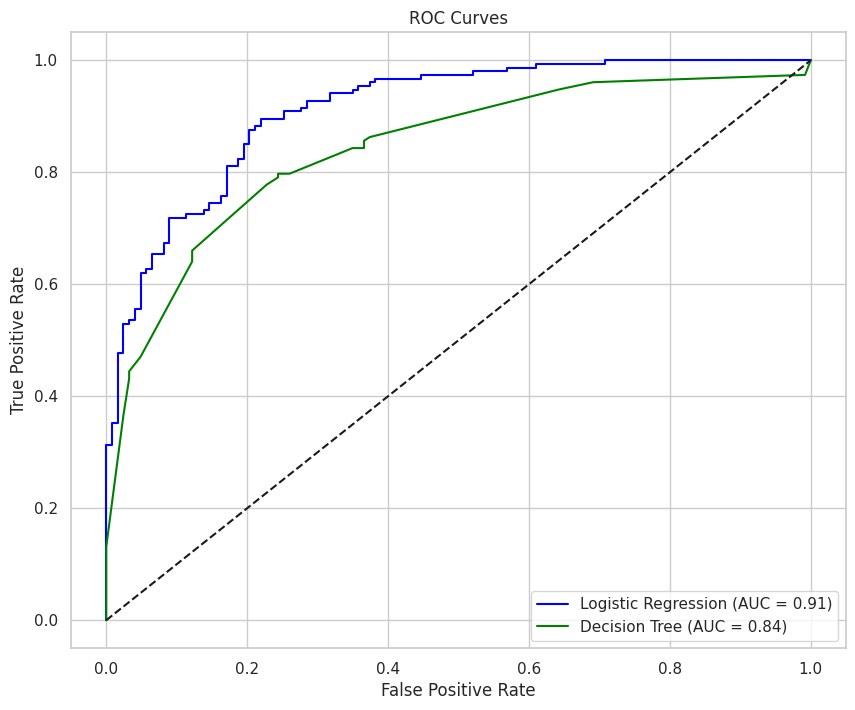

In [28]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
models = [('Logistic Regression', best_logreg), ('Decision Tree', best_dtree)]
colors = ['blue', 'green']

for (name, model), color in zip(models, colors):
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})', color=color)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

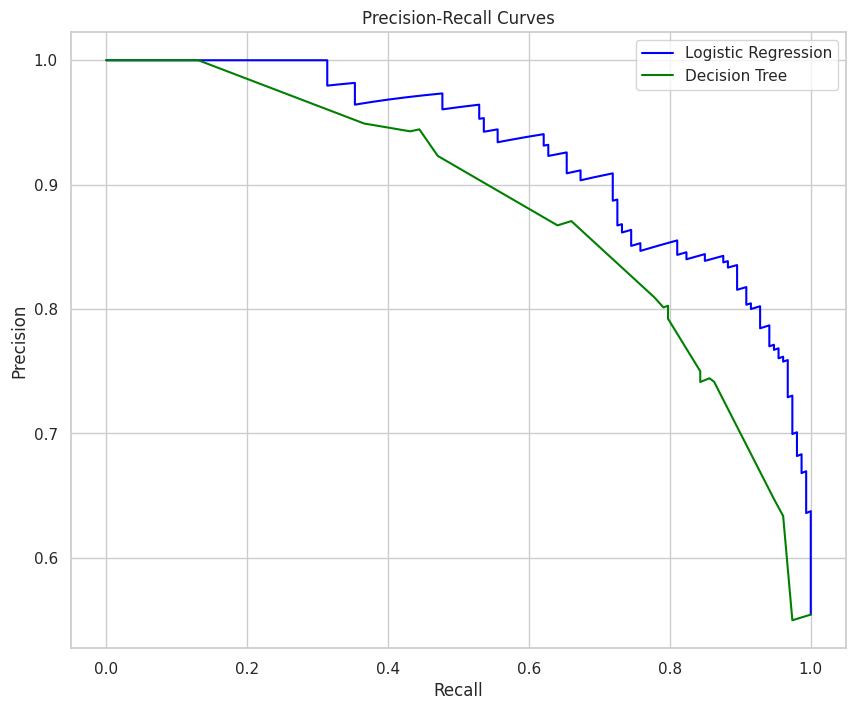

In [29]:
# Plot precision-recall curves
plt.figure(figsize=(10, 8))
for (name, model), color in zip(models, colors):
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, label=name, color=color)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

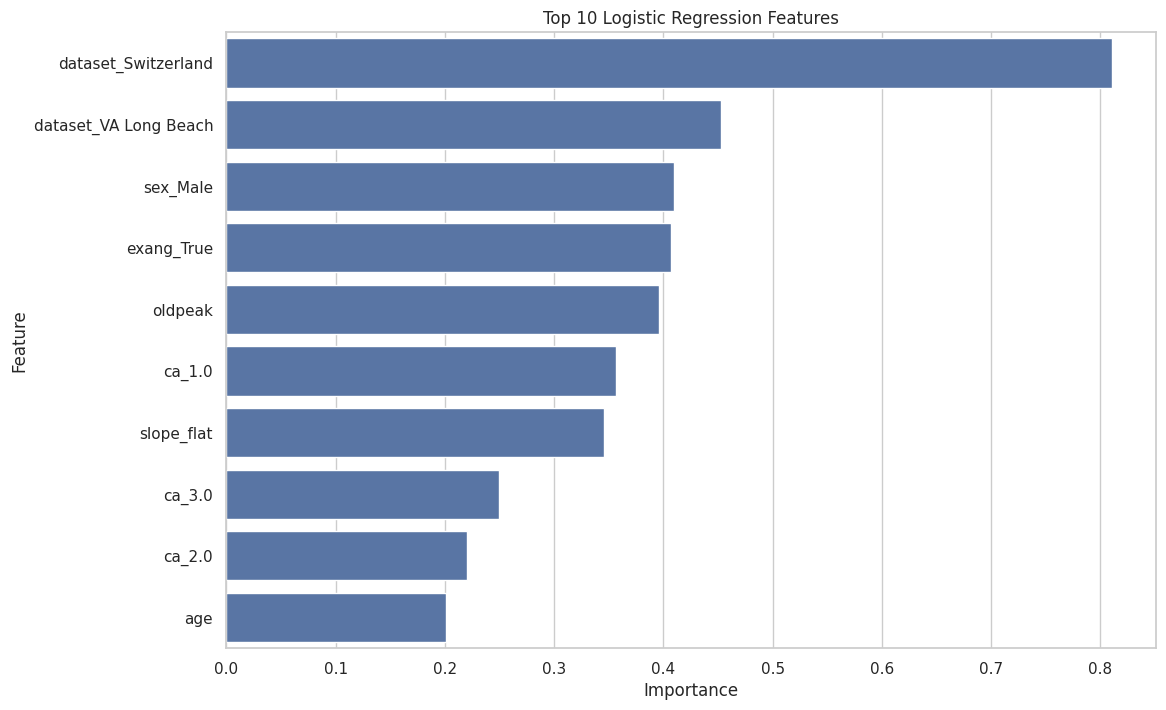

In [30]:
# Feature importance for logistic regression
try:
    # Extract logistic regression model from pipeline
    logreg_model = best_logreg.named_steps['logisticregression']
    logreg_feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': logreg_model.coef_[0]
    })
    logreg_feature_importance = logreg_feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=logreg_feature_importance.head(10))
    plt.title('Top 10 Logistic Regression Features')
    plt.show()
except AttributeError:
    print("Could not extract logistic regression coefficients")


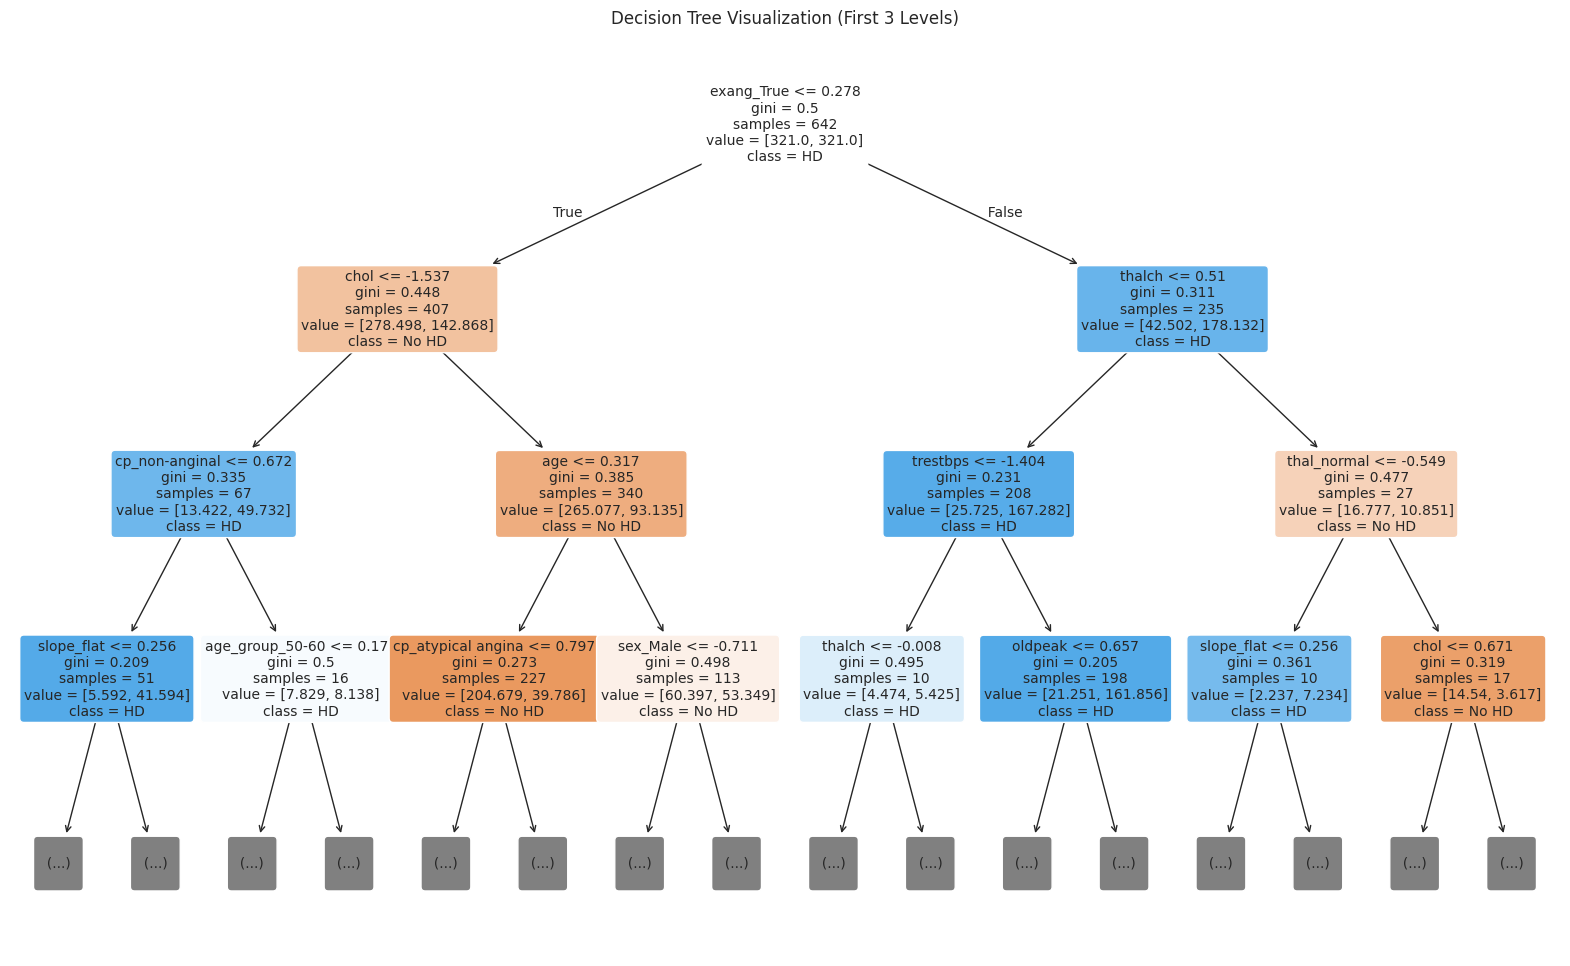


Feature importance for decision tree


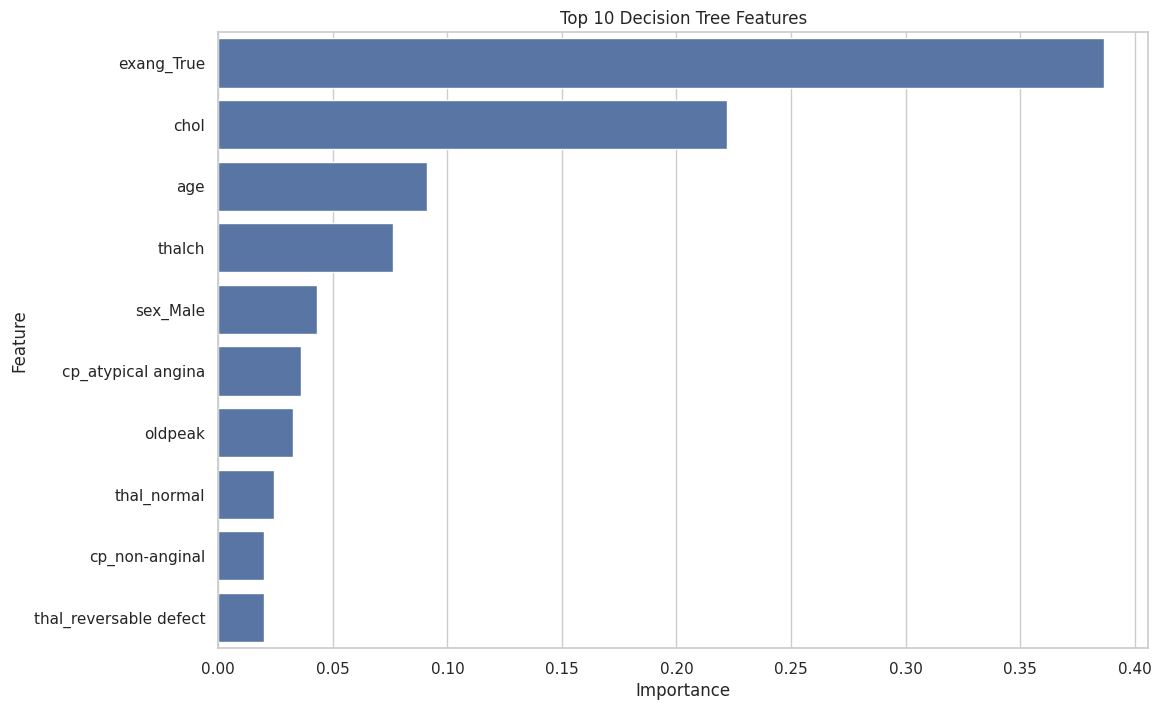

In [31]:
try:
    # Extract the decision tree model from the pipeline
    dtree_model = best_dtree.named_steps['decisiontreeclassifier']

    # Visualize decision tree
    plt.figure(figsize=(20, 12))
    plot_tree(dtree_model,
              feature_names=X.columns,
              class_names=['No HD', 'HD'],
              filled=True,
              rounded=True,
              max_depth=3,
              fontsize=10)
    plt.title('Decision Tree Visualization (First 3 Levels)')
    plt.show()


    # Feature importance for decision tree
    print("\n" + "="*100)
    print("Feature importance for decision tree")
    print("="*100)

    dtree_feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': dtree_model.feature_importances_
    })
    dtree_feature_importance = dtree_feature_importance.sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=dtree_feature_importance.head(10))
    plt.title('Top 10 Decision Tree Features')
    plt.show()
except KeyError:
    print("Could not extract decision tree from pipeline")
except AttributeError:
    print("Decision tree visualization failed")

### **Final Comparison**

In [32]:
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Logistic Regression': [
        logreg_metrics['Accuracy'],
        logreg_metrics['Precision'],
        logreg_metrics['Recall'],
        logreg_metrics['F1'],
        logreg_metrics['ROC AUC']
    ],
    'Decision Tree': [
        dtree_metrics['Accuracy'],
        dtree_metrics['Precision'],
        dtree_metrics['Recall'],
        dtree_metrics['F1'],
        dtree_metrics['ROC AUC']
    ]
})

print(comparison)

      Metric  Logistic Regression  Decision Tree
0   Accuracy             0.818841       0.771739
1  Precision             0.855172       0.792208
2     Recall             0.810458       0.797386
3   F1 Score             0.832215       0.794788
4    ROC AUC             0.911526       0.841570
